In [8]:
import pandas as pd
import numpy as np
import xgboost as xgb
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter

# Set plot style for better visuals
sns.set_style("whitegrid")

In [9]:
AORTA_FILE_NAME="aortaP_train_data.csv"
BRACH_FILE_NAME="brachP_train_data.csv"

### Filled the NaNs with interpolation 
### Smoothened the data
### Concatenated the aortal and brachial dataset

In [17]:
def load_and_preprocess_data(aorta_path, brachial_path):
    # 1. Load the datasets
    # index_col=0 handles the first unnamed column acting as the index
    df_aorta = pd.read_csv(aorta_path, index_col=0)
    df_brachial = pd.read_csv(brachial_path, index_col=0)
    
    # 2. Extract Target
    # 'target' is identical in both files. We take it from one and drop it from features.
    if 'target' in df_aorta.columns:
        y = df_aorta['target']
        df_aorta = df_aorta.drop(columns=['target'])
    df_aorta = df_aorta.interpolate(axis=1, limit_direction='both').fillna(0)
    
    if 'target' in df_brachial.columns:
        # We perform a check just in case, but we will drop it from brachial features
        df_brachial = df_brachial.drop(columns=['target'])
    df_brachial = df_brachial.interpolate(axis=1, limit_direction='both').fillna(0)
    
    aorta_smoothed_array = savgol_filter(df_aorta.astype(float), 
                               window_length=31, 
                               polyorder=3, 
                               axis=1)
    
    df_aorta = pd.DataFrame(aorta_smoothed_array, 
                        index=df_aorta.index, 
                        columns=df_aorta.columns)
    
    brachial_smoothed_array = savgol_filter(df_brachial.astype(float), 
                                   window_length=31, 
                                   polyorder=3, 
                                   axis=1)
    
    df_brachial = pd.DataFrame(brachial_smoothed_array, 
                            index=df_brachial.index, 
                            columns=df_brachial.columns)
    
    # 3. Merge Features
    # We join on the index to ensure the rows match up perfectly
    X = pd.concat([df_aorta, df_brachial], axis=1)
    
    print(f"Features shape: {X.shape}")
    print(f"Labels shape: {y.shape}")
    
    return X, y


In [18]:
def train_xgboost_model(X, y, test_size=0.2, random_state=42):
    # 1. Split Data
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    # 2. Initialize Model
    model = xgb.XGBClassifier(
        n_estimators=200, 
        learning_rate=0.1, 
        max_depth=5,
        eval_metric=['merror', 'mlogloss'], # Monitor error and logloss
        early_stopping_rounds=10
    )
    
    # 3. Fit Model
    print("Training model...")
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        verbose=True 
    )
    
    print("Training Complete.")
    return model, X_val, y_val

In [19]:
def plot_confusion_matrix_custom(model, X_val, y_val):
    """
    Predicts values for X_val and plots the confusion matrix.
    """
    # Predict
    y_pred = model.predict(X_val)
    
    # Calculate Matrix
    cm = confusion_matrix(y_val, y_pred)
    
    # Plot
    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='d')
    
    plt.title('Confusion Matrix')
    plt.grid(False) # Turn off grid for CM as it looks messy
    plt.show()

def plot_training_history(model):
    """
    Plots the validation and training accuracy/error over epochs.
    """
    results = model.evals_result()
    epochs = len(results['validation_0']['merror'])
    x_axis = range(0, epochs)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot Log Loss
    ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train Log Loss')
    ax.plot(x_axis, results['validation_1']['mlogloss'], label='Validation Log Loss')
    
    # Create a secondary axis for Classification Error
    ax2 = ax.twinx()
    ax2.plot(x_axis, results['validation_0']['merror'], label='Train Error', linestyle='--', alpha=0.5)
    ax2.plot(x_axis, results['validation_1']['merror'], label='Validation Error', linestyle='--', alpha=0.5)
    
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Log Loss')
    ax2.set_ylabel('Classification Error')
    
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')
    
    plt.title('XGBoost Training & Validation Learning Curves')
    plt.show()

In [20]:
# ==========================================
# MAIN EXECUTION
# =========================================

# Load
print("--- Loading Data ---")
X, y = load_and_preprocess_data(AORTA_FILE_NAME, BRACH_FILE_NAME)

# Train
print("\n--- Training Model ---")
model, X_val, y_val = train_xgboost_model(X, y)


--- Loading Data ---
Features shape: (3499, 672)
Labels shape: (3499,)

--- Training Model ---
Training model...
[0]	validation_0-merror:0.40729	validation_0-mlogloss:1.70161	validation_1-merror:0.53286	validation_1-mlogloss:1.72425
[1]	validation_0-merror:0.37763	validation_0-mlogloss:1.62680	validation_1-merror:0.50286	validation_1-mlogloss:1.66878
[2]	validation_0-merror:0.35263	validation_0-mlogloss:1.56015	validation_1-merror:0.49714	validation_1-mlogloss:1.61656
[3]	validation_0-merror:0.35048	validation_0-mlogloss:1.49739	validation_1-merror:0.48286	validation_1-mlogloss:1.56803
[4]	validation_0-merror:0.31476	validation_0-mlogloss:1.43899	validation_1-merror:0.47143	validation_1-mlogloss:1.52343
[5]	validation_0-merror:0.30975	validation_0-mlogloss:1.38685	validation_1-merror:0.46000	validation_1-mlogloss:1.48522
[6]	validation_0-merror:0.30011	validation_0-mlogloss:1.34187	validation_1-merror:0.46143	validation_1-mlogloss:1.45335
[7]	validation_0-merror:0.29546	validation_0-ml


--- Plotting Results ---


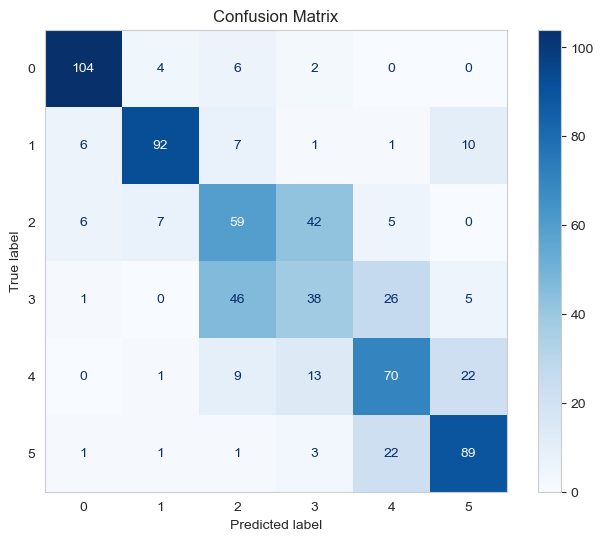

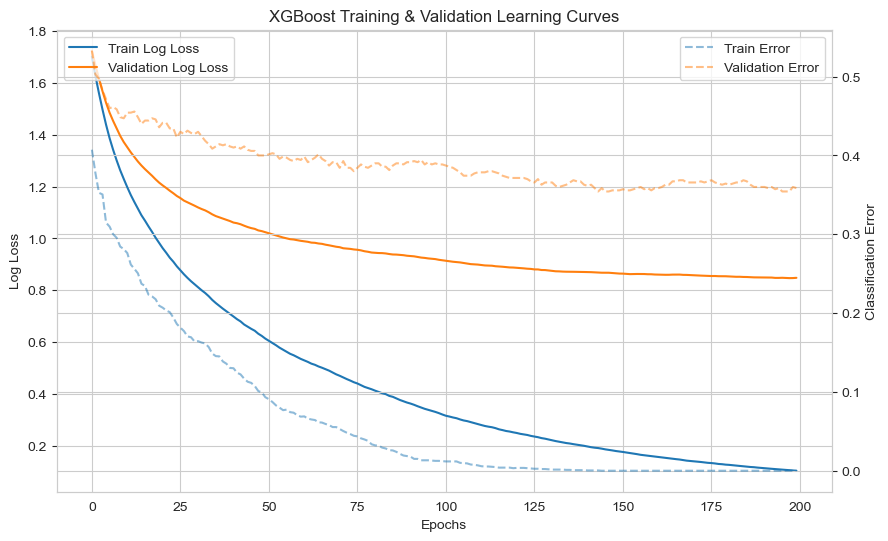

Final Validation Accuracy: 0.6443


In [21]:
# Evaluate
print("\n--- Plotting Results ---")

plot_confusion_matrix_custom(model, X_val, y_val)

plot_training_history(model)

print(f"Final Validation Accuracy: {f1_score(y_val, model.predict(X_val), average='weighted'):.4f}")